# Quantitative MRI: Confounding Factors and Bias

In [14]:
## MP 573 Lecture 1: One- and multi-dimensional signals
##
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
import matplotlib.image as mpimg
from os.path import dirname, join as pjoin
import scipy.io as sio
from dataclasses import dataclass
from scipy.optimize import curve_fit
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [15]:
@dataclass
class trueParams:
    A: float
    ff: float
    r2star: float
    fieldmap: float = 0.0
        
@dataclass
class imDataParams:
    FieldStrength: float
    TE: list
        

@dataclass
class algoParams:
    fatFreqs: list
    fatAmps: list
    USE_R2: bool    
        

def create_signal(imP, trueP, algoP):
    sw = trueP.A*(1-trueP.ff*0.01)*np.ones(len(imP.TE))
    sf = 0*imP.TE
    
    for n in range(0, len(algoP.fatFreqs)):
        sf = sf + algoP.fatAmps[n]*trueP.A*trueP.ff*0.01*np.exp(1j*2*np.pi*imP.TE*algoP.fatFreqs[n]*imP.FieldStrength*42.576)
        #sf = sf + imP.TE
    s = sw + sf
    
    if algoP.USE_R2:
        s = s*np.exp(-imP.TE*trueP.r2star + 1j*2*np.pi*imP.TE*trueP.fieldmap)
    else:
        s = s*np.exp(1j*2*np.pi*imP.TE*trueP.fieldmap)
    
    return s

def create_signal_r2star(TE, A, ff, r2star):
    
    global myImDataParams
    global myAlgoParams
    
    fieldmap = 0
    myTrueParams = trueParams(A, ff, r2star,fieldmap)

    s = create_signal(myImDataParams, myTrueParams, myAlgoParams)
    
    s2 = np.abs(s)
    
    return s2


def create_signal_nor2star(TE, A, ff):
    
    global myImDataParams
    global myAlgoParams
    
    r2star = 0
    fieldmap = 0
    myTrueParams = trueParams(A, ff, r2star,fieldmap)

    s = create_signal(myImDataParams, myTrueParams, myAlgoParams)
    
    s2 = np.abs(s)
    
    return s2





font = {'weight' : 'normal',
        'size'   : 20}

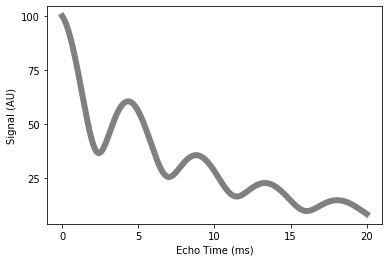

In [16]:
global myAlgoParams 
global myImDataParams
global t
global s1

N = 1001
tmax = 20*0.001
t = np.linspace(0.0,tmax,N)

myTrueParams = trueParams(100., 30., 100., 0.)

fFreq = [-3.80, -3.40, -2.60, -1.94, -0.39, 0.60];
fAmps = [0.087, 0.693, 0.128, 0.004, 0.039, 0.048];
myAlgoParams = algoParams(fFreq, fAmps, True )

myImDataParams = imDataParams(1.5, t)
s1 = create_signal(myImDataParams, myTrueParams , myAlgoParams);

plt.plot(t*1000,abs(s1),'gray',linewidth=6.0);
plt.xlabel('Echo Time (ms)');
plt.ylabel('Signal (AU)');
plt.rc('font', **font)


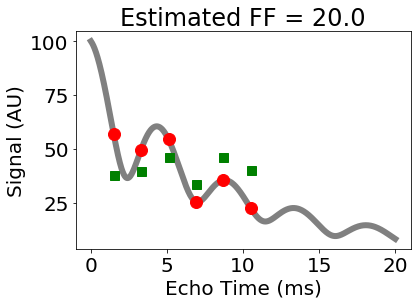

In [17]:
TE1 = 1.5*0.001
dTE = 1.8*0.001
nTE = 6
TE = np.linspace(TE1,TE1 + (nTE-1)*dTE,nTE)
myImDataParams = imDataParams(1.5, TE)
s = create_signal(myImDataParams, myTrueParams , myAlgoParams);

fFreq = [ -3.40];
fAmps = [ 0.693];
myAlgoParams = algoParams(fFreq, fAmps, True )

p0 = np.array([90.,40.])
popt, pcov = curve_fit(create_signal_nor2star, TE, abs(s), p0);
sfit = create_signal_nor2star( TE, popt[0], popt[1])

plt.plot(t*1000,abs(s1),'gray',linewidth=6.0);
plt.plot(TE*1000,abs(s),'or',markersize=12);
plt.plot(TE*1000,abs(sfit),'sg',markersize=9);
plt.xlabel('Echo Time (ms)');
plt.ylabel('Signal (AU)');
plt.rc('font', **font)
plt.title('Estimated FF = ' '{:.3}'.format(popt[1]));

In [20]:
def showFit(dTE):
    global myAlgoParams 
    global myImDataParams
    global t
    global s1
    TE1 = 1.5*0.001
#    dTE = 1.8*0.001
    nTE = 6
    TE = np.linspace(TE1,TE1 + (nTE-1)*dTE,nTE)
    myImDataParams = imDataParams(1.5, TE)
    s = create_signal(myImDataParams, myTrueParams , myAlgoParams);

    fFreq = [ -3.40];
    fAmps = [ 0.693];
    myAlgoParams = algoParams(fFreq, fAmps, True )

    p0 = np.array([90.,40.])
    popt, pcov = curve_fit(create_signal_nor2star, TE, abs(s), p0);
    sfit = create_signal_nor2star( TE, popt[0], popt[1])

    plt.plot(t*1000,abs(s1),'gray',linewidth=6.0);
    plt.plot(TE*1000,abs(s),'or',markersize=12);
    plt.plot(TE*1000,abs(sfit),'sg',markersize=9);
    plt.xlabel('Echo Time (ms)');
    plt.ylabel('Signal (AU)');
    plt.rc('font', **font)
    plt.title('Estimated FF = ' '{:.3}'.format(popt[1]));
    

In [21]:
## Create interactive slide bar
y = interactive(showFit,dTE=(0.6,4.0,0.2))
display(y)

interactive(children=(FloatSlider(value=2.2, description='dTE', max=4.0, min=0.6, step=0.2), Output()), _dom_c…